**Notebook credit**: based on the F. Chollet's original notebook [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter05_fundamentals-of-ml.ipynb).

# Fundamentals of machine learning

## Generalization: The goal of machine learning

- we have looked at predicting movie reviews and house-price regression
- we split the data into a training set, a validation set, and a test set
- we should not evaluate the models on the same data they
were trained
- after just a few epochs, performance on never-before-seen data started diverging from performance on the training data
- training data performance always improves as training progresses
- at some point, the models started to **overfit**



**The fundamental issue in ML is the tension between optimization and generalization**

- optimization: process of adjusting a model to get the best performance possible on the training data
- generalization: how well the trained model performs on data it has never seen before
- key challenge: our *goal* is good generalization we can't directly control generalization
- can only fit the model to its training data
- do that too well: overfitting kicks in and generalization suffers

### Underfitting and overfitting

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/overfitting.png" width="500">


### 什么时候容易发生 Overfitting
Overfitting is particularly likely to occur when your data:
- is noisy
- involves uncertainty
- includes rare features

**Adding white-noise channels or all-zeros channels to MNIST**

- we will create new training set by concatenating 784 white noise dimensions to the existing 784 dimensions of the data
- we will also create an equivalent dataset by concatenating 784 all-zeros dimensions
- concatenation of meaningless features does not at all affect the information content of the data
- human classification accuracy wouldn't be affected by these transformations at all


In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate( # add 784 features that are pure noise
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate( # add 784 features that are all-zeros
    [train_images, np.zeros((len(train_images), 784))], axis=1)

**Training the same model on MNIST data with noise channels or all-zero channels**

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2) # use first 80% as training, rest 20% as validation

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 8s 19ms/step - loss: 0.6128 - accuracy: 0.8105 - val_loss: 0.3098 - val_accuracy: 0.9064
Epoch 2/10
375/375 [==============================] - 6s 17ms/step - loss: 0.2537 - accuracy: 0.9210 - val_loss: 0.2237 - val_accuracy: 0.9277
Epoch 3/10
375/375 [==============================] - 7s 19ms/step - loss: 0.1640 - accuracy: 0.9493 - val_loss: 0.1750 - val_accuracy: 0.9493
Epoch 4/10
375/375 [==============================] - 6s 17ms/step - loss: 0.1184 - accuracy: 0.9634 - val_loss: 0.1351 - val_accuracy: 0.9622
Epoch 5/10
375/375 [==============================] - 7s 19ms/step - loss: 0.0865 - accuracy: 0.9726 - val_loss: 0.1215 - val_accuracy: 0.9642
Epoch 6/10
375/375 [==============================] - 6s 16ms/step - loss: 0.0652 - accuracy: 0.9797 - val_loss: 0.1308 - val_accuracy: 0.9626
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 0.0487 - accuracy: 0.9849 - val_loss: 0.1345 - val_accuracy: 0.9625

**Plotting a validation accuracy comparison**

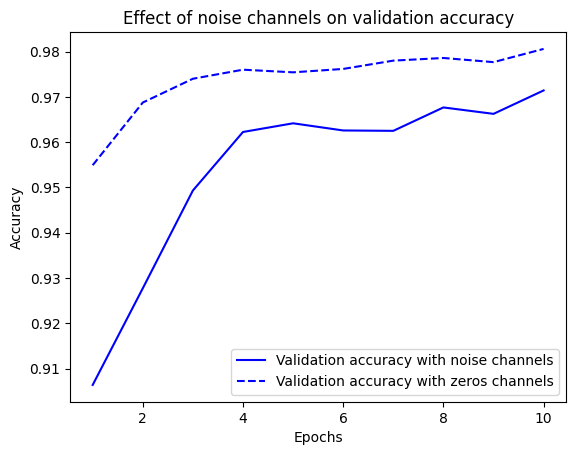

In [7]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## The nature of generalization in deep learning

- deep learning models can be trained to fit anything, as long as they have enough representational power
- we will look at this "universal approximation" property later on in the course
- for now we will see a particular manifestation of this power
- 我们 shuffle the MNIST labels 然后基于这个乱七八糟的数据集来训练一个模型. 现在 inputs 和 shuffled labels 之间没有任何关系了.
- 即便如此, 并且即使模型相对较小, training loss 也会 decrease over time
- 但是自然地, the validation loss 不会随着 training loss 有任何改进.

#### **Fitting a MNIST model with randomly shuffled labels**

In [9]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=10,                         # increasing this will further increase the gap between training and validation accuracies
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 10s 23ms/step - loss: 2.3166 - accuracy: 0.1044 - val_loss: 2.3051 - val_accuracy: 0.1076
Epoch 2/10
375/375 [==============================] - 8s 21ms/step - loss: 2.2993 - accuracy: 0.1174 - val_loss: 2.3114 - val_accuracy: 0.1052
Epoch 3/10
375/375 [==============================] - 5s 12ms/step - loss: 2.2921 - accuracy: 0.1269 - val_loss: 2.3135 - val_accuracy: 0.1024
Epoch 4/10
375/375 [==============================] - 7s 18ms/step - loss: 2.2801 - accuracy: 0.1386 - val_loss: 2.3263 - val_accuracy: 0.1007
Epoch 5/10
375/375 [==============================] - 4s 12ms/step - loss: 2.2648 - accuracy: 0.1501 - val_loss: 2.3315 - val_accuracy: 0.1078
Epoch 6/10
375/375 [==============================] - 7s 17ms/step - loss: 2.2448 - accuracy: 0.1653 - val_loss: 2.3474 - val_accuracy: 0.1028
Epoch 7/10
375/375 [==============================] - 8s 20ms/step - loss: 2.2217 - accuracy: 0.1811 - val_loss: 2.3622 - val_accuracy: 0.101

### The manifold hypothesis(流形假设): deep learning 生效的根本原因

首先 manifold 的定义:(非严谨, 严谨定义参照 manifolds)
A "manifold" is a lower-dimensional subspace of some parent space that is locally similar to a linear (Euclidean) space.

例如: a smooth curve in the plane is a 1D manifold within a 2D space, because for every point of the curve, you can draw a tangent. 又例如 a smooth surface within a 3D space is a 2D manifold

我们看到 MNIST 数据集.
- The space of 28 x 28 images with integer pixel values between 0 and 255 是一个比较大的 space, 而 MNIST samples 中的 handwritten digits 则是它的一个 tiny subspace.

- 这个 subspace 是 highly structured 的:
  - 它是 continuous 的: if you take a sample and modify it a little, it will still be recognizable as the same handwritten digit.
  - **这个 subspace 中的所有 samples 都是 connected by smooth paths that run through the subspace.** 即: 任取两个 random MNIST digits A and B, 都存在一系列的 “intermediate” images that morph A into B.

- 因而我们称: handwritten digits form a **manifold** within the space of possible 28 × 28 `uint8` arrays

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/MNIST_morphing.png" width="500">

#### The manifold hypothesis 的具体内容: All natural data lies on a low-dimensional manifold within the high-dimensional space where it is encoded.

这是一个关于这个世界的信息结构的一个非常强的 statement. 并且我们认为这是 accurate 的, and it's the reason why deep learning works
  - MNIST digits
  - human faces
  - tree morphology
  - sounds of the human voice
  - natural language

The manifold hypothesis implies:
- Machine learning models 只能把 relatively simple, low-dimensional, highly structured subspaces 给 fit 进它们的 potential input space (latent manifolds).
- 我们总是能够 *interpolate* between two inputs, that is to say, morph one into another via a continuous path along which all points fall on the manifold.
- The ability to interpolate between samples is the key to understanding generalization in deep learning.

`begin side note`

(*) it is natural to wonder what is the empirical evidence in favor of the manifold hypothesis. there is theoretical work on testing the manifold hypothesis:

[Testing the Manifold Hypothesis](https://arxiv.org/abs/1310.0425) by Charles Fefferman, Sanjoy Mitter, Hariharan Narayanan

but don't know if anyone has actually tested the hypothesis on empirical data. possible undergraduate thesis topic here?

`end side note`

#### Interpolation(插值) as a source of generalization

- if you have data points that can be interpolated, you can start making sense of points you've never seen before
- you can relate new points to other points that lie close on the manifold
- you can make sense of the totality of the space using only a sample of the space
- you can use interpolation to fill in the blanks
- interpolation on the latent manifold is different from linear interpolation in the parent space

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/manifold_interpolation.png" width="500">

#### Why deep learning works: fit 和 overfit 的形象化

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/why_deep_learning_works.png" height="500">

#### Training data is paramount

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/training_data_paramount.png" height="300">

- suppose getting more data isn't possible
- the next best solution is to control model complexity
- or to add constraints on the smoothness of the model curve
- the process of fighting overfitting this way is called *regularization*
- we will review regularization techniques soon
- before you can start tweaking your model to help it generalize better, you'll need a way to assess how your model is currently doing
- therefore we next look at _model evaluation_

## Evaluating machine-learning models

### Training, validation, and test sets


- evaluating a model always boils down to splitting the available data into three sets: training, validation, and test
- train on the training data and evaluate your model on the validation data
- once your model is ready for prime time, you test it one final time on the test data, which is meant to be as similar as possible to production data
- then you can deploy the model in production

_Why not have two sets: a training set and a test set? You’d train on the training data and evaluate on the test data. Much simpler!_

- developing a model always involves tuning its configuration:
  - choosing the number of layers
  - the size of the layers
- these are called *hyperparameters* to distinguish them from the parameters (which are the network’s weights)
- this tuning is done by using as a feedback signal the performance of the model on the validation data

#### Simple hold-out validation

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/holdout_validation.png" width="500">

#### K-fold validation

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/K-fold_validation.png" width="600">

#### Iterated K-fold validation with shuffling

- this is for situations in which you have relatively little data available and you need to evaluate your model as precisely as possible
- consists of applying K-fold validation multiple times
- shuffle the data every time before splitting it `K` ways
- final score is the average of the scores obtained at each run of K-fold validation
- you end up training and evaluating `P * K` models (where `P` is the number of iterations you use), which can be very expensive.

### Beating a common-sense baseline

Important to ensure yor trained network is doing better than some simple baseline

- in the MNIST digit-classification example, a simple baseline would be a validation accuracy greater than 0.1 (random classifier)
- in the IMDB example, it would be a validation accuracy greater than 0.5
- **class imbalance**: you have a binary classification problem where 90% of samples belong to class A and 10% belong to class B
  - a classifier that always predicts A already achieves 0.9 in validation accuracy
  - you’ll need to do better than that